In [4]:
import dpkt
import codecs
from scapy.all import *
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
def conv_pcap_to_csv(fname):
#     rdpcap is the python function to read data from pcap file
    packets=rdpcap(fname)
    output_file='Datasets/data_captured_spoof.csv'
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['dst_IP', 'src_IP', 'TCP_sport','TCP_dport', 'TCP_seq_num', 'TCP_ack_num', 'TCP_data_offset', 
                      'TCP_reserved', 'TCP_flags','TCP_window', 'TCP_chksum','TCP_urgptr','TCP_options','Attack']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for pkt in packets:
            if pkt.haslayer(TCP):
                writer.writerow({'dst_IP': str(pkt.dst), 'src_IP': str(pkt.src), 'TCP_sport': str(pkt.getlayer(TCP).sport),
                          'TCP_dport': str(pkt.getlayer(TCP).dport), 'TCP_seq_num': str(pkt.getlayer(TCP).seq), 'TCP_ack_num': str(pkt.getlayer(TCP).ack), 
                          'TCP_data_offset': str(pkt.getlayer(TCP).dataofs), 'TCP_reserved': str(pkt.getlayer(TCP).reserved), 
                          'TCP_flags': str(pkt.getlayer(TCP).flags),'TCP_window': str(pkt.getlayer(TCP).window), 'TCP_chksum': str(pkt.getlayer(TCP).chksum),
                          'TCP_urgptr': str(pkt.getlayer(TCP).urgptr),'TCP_options': str(pkt.getlayer(TCP).options),'Attack':1})
    
    print("Conversion completed successfully!!!")
    return output_file

In [2]:
def extract_num_features(data, subset_packets, total_packets):
    print("Total packets captured in the file: ",total_packets)
    nack = []
    nsyn = []
    npa = []
    nfa = []
    nsa = []
    ratio_syn_ack = []
    ratio_fin_ack = []    
    attack_list = []
    
    for i in range(subset_packets,total_packets,subset_packets):
#         this will take batches of packets and extract meaningful numerical data
        k=i-subset_packets
#         print("val of k: ",k)
#         print("val of i: ", i)
#         print("")
        data_subset=data[k:i]
#         print(data_subset.shape)
#         print(data_subset.head().T)
#         print(train_data_subset.iloc[j,27])
        flags = data_subset['TCP_flags'].value_counts()

        if 'A' in flags: 
            nack.append(flags.get('A'))
        else: 
            nack.append(0)
    
        if 'S' in flags: 
            nsyn.append(flags.get('S'))
        else: 
            nsyn.append(0)
    
        if 'PA' in flags: 
            npa.append(flags.get('PA'))
        else: 
            npa.append(0)
            
            
        if 'FA' in flags: 
            nfa.append(flags.get('FA'))
        else: 
            nfa.append(0)

        if 'SA' in flags: 
            nsa.append(flags.get('SA'))
        else: 
            nsa.append(0)

        if 'A' in flags and 'S' in flags:
            ratio_syn_ack.append(flags.get('S')/flags.get('A'))
        elif 'A' not in flags and 'S' not in flags:
            ratio_syn_ack.append(0)
        elif 'A' not in flags:
            ratio_syn_ack.append(flags.get('S'))
        elif 'S' not in flags:
            ratio_syn_ack.append(1/flags.get('A'))

        if 'F' in flags and 'A' in flags:    
            ratio_fin_ack.append(flags.get('F')/flags.get('A'))
        elif 'F' not in flags and 'A' not in flags:
            ratio_fin_ack.append(0)
        elif 'F' not in flags:
            ratio_fin_ack.append(1/flags.get('A'))
        elif 'A' not in flags:
            ratio_fin_ack.append(flags.get('F'))         

        attack_rate = 0
        for index, row in data_subset.iterrows():
            attack_rate = attack_rate + row['Attack']
        attack_list.append(row['Attack'])
        
#     capturing the numerical data for the last packet. After the execution of the above loop the variable 'i' will have the value o total_packets - 1
    data_subset=data[i:total_packets]
    flags = data_subset['TCP_flags'].value_counts()
    attack_rate = 0
    for index, row in data_subset.iterrows():
        attack_rate = attack_rate + row['Attack']
    attack_list.append(row['Attack'])

    if 'A' in flags: 
        nack.append(flags.get('A')) 
    else: 
        nack.append(0)
     
    if 'S' in flags: 
        nsyn.append(flags.get('S'))
    else: 
        nsyn.append(0)

    if 'PA' in flags: 
        npa.append(flags.get('PA'))
    else: 
        npa.append(0)
  
    if 'FA' in flags: 
        nfa.append(flags.get('FA'))
    else: 
        nfa.append(0)
        
    if 'SA' in flags: 
        nsa.append(flags.get('SA'))
    else: 
        nsa.append(0)
 
    if 'A' in flags and 'S' in flags:
        ratio_syn_ack.append(flags.get('S')/flags.get('A'))
    elif 'A' not in flags and 'S' not in flags:
        ratio_syn_ack.append(0)
    elif 'A' not in flags:
        ratio_syn_ack.append(flags.get('S'))
    elif 'S' not in flags:
        ratio_syn_ack.append(1/flags.get('A'))
   
    if 'F' in flags and 'A' in flags:    
        ratio_fin_ack.append(flags.get('F')/flags.get('A'))
    elif 'F' not in flags and 'A' not in flags:
        ratio_fin_ack.append(0)
    elif 'F' not in flags:
        ratio_fin_ack.append(1/flags.get('A'))
    elif 'A' not in flags:
        ratio_fin_ack.append(flags.get('F'))    

    extracted_num_data= pd.DataFrame()
    extracted_num_data['nack']=nack
    extracted_num_data['nsyn']=nsyn
    extracted_num_data['npa']=npa
    extracted_num_data['nfa']=nfa
    extracted_num_data['nsa']=nsa
    extracted_num_data['ratio_syn_ack']=ratio_syn_ack
    extracted_num_data['ratio_fin_ack']=ratio_fin_ack
    extracted_num_data['attack']=attack_list
    
    return extracted_num_data


In [5]:
print("Converting Non- Malicious Pcap file to CSV!!!")
fname = 'Datasets/ncap.pcap'
ncapcsv = conv_pcap_to_csv(fname)
print("Non Malicious csv file name "+ ncapcsv )
# Converting the csv file to a dataset
data_normal = pd.read_csv(ncapcsv)

Converting Non- Malicious Pcap file to CSV!!!
Conversion completed successfully!!!
Non Malicious csv file name Datasets/data_captured_normal.csv


In [7]:
# extracting features from spoof pcap
print("Converting Malicious Pcap file to CSV!!!")
fname = 'Datasets/syn_flood.pcap'
syn_floodcsv = conv_pcap_to_csv(fname)
print("Malicious csv file name "+ syn_floodcsv )
# Converting the csv file to a dataset
data_spoof = pd.read_csv(syn_floodcsv)

Converting Malicious Pcap file to CSV!!!
Conversion completed successfully!!!
Malicious csv file name Datasets/data_captured_spoof.csv


In [8]:
print("Starting Data Preprocessing!!!")
print("Step 1: Sampling the large Dataset!!! ")
red_data_normal=data_normal.sample(n=10000)
red_data_spoof=data_spoof.sample(n=10000)

Starting Data Preprocessing!!!
Step 1: Sampling the large Dataset!!! 


In [9]:
# combine the 2 datasets rowwise
print("\n Step 2: Combining the two datasets into one dataset!!!")
final_dataset = pd.concat([red_data_normal, red_data_spoof], axis=0)
final_dataset.to_csv("Datasets/finaldataset.csv", index=False)
# print(final_dataset)


 Step 2: Combining the two datasets into one dataset!!!


In [10]:
# shuffle the dataset
print("\n Step 3: Shuffle the dataset!!! ")
sfinal_dataset = pd.DataFrame()
sfinal_dataset = final_dataset.sample(frac=1)
sfinal_dataset.to_csv("Datasets/sfinaldataset.csv", index=False)


 Step 3: Shuffle the dataset!!! 


In [11]:
print("\n Step 4: Finding the dimensions and datatype of the dataset!!!")
print("Dim of dataset: ", sfinal_dataset.shape)
print("Datatype of dataset:\n ", sfinal_dataset.dtypes)


 Step 4: Finding the dimensions and datatype of the dataset!!!
Dim of dataset:  (20000, 14)
Datatype of dataset:
  dst_IP             object
src_IP             object
TCP_sport           int64
TCP_dport           int64
TCP_seq_num         int64
TCP_ack_num         int64
TCP_data_offset     int64
TCP_reserved        int64
TCP_flags          object
TCP_window          int64
TCP_chksum          int64
TCP_urgptr          int64
TCP_options        object
Attack              int64
dtype: object


In [12]:
print("\n Step 5: Starting Feature Extraction...")
total_packets=sfinal_dataset.shape[0] 
subset_packets = 5
extracted_num_data = extract_num_features(sfinal_dataset, subset_packets, total_packets)
print("Feature Extraction Completed!")
print()
extracted_num_data.to_csv('Datasets/num_data_extracted.csv')


 Step 5: Starting Feature Extraction...
Total packets captured in the file:  20000
Feature Extraction Completed!



In [13]:
print("\n Redoing Step 4: Finding the dimensions and datatype of the dataset!!!")
print("Dim of dataset: ", extracted_num_data.shape)
print("Datatype of dataset:\n ", extracted_num_data.dtypes)


 Redoing Step 4: Finding the dimensions and datatype of the dataset!!!
Dim of dataset:  (4000, 8)
Datatype of dataset:
  nack               int64
nsyn               int64
npa                int64
nfa                int64
nsa                int64
ratio_syn_ack    float64
ratio_fin_ack    float64
attack             int64
dtype: object


In [10]:
# print("Starting Preprocessing...")
# sfinal_dataset = sfinal_dataset.drop(sfinal_dataset.columns[[0,1]], axis=1)
# # sfinal_dataset['dst'] = sfinal_dataset['dst'].astype('category')
# # sfinal_dataset['src'] = sfinal_dataset['src'].astype('category')
# # sfinal_dataset['IP flags'] = sfinal_dataset['IP flags'].astype('string')
# # sfinal_dataset['TCP flags'] = sfinal_dataset['TCP Flags'].astype('category')
# sfinal_dataset['Label'] = sfinal_dataset['Label'].astype('string')
# sfinal_dataset['TCP flags'] = sfinal_dataset['TCP flags'].astype('string')
# print("Done Preprocessing...")

Starting Preprocessing...
Done Preprocessing...


Step 6: Calculating Correlation between variables:
                   nack      nsyn       npa       nfa       nsa  \
nack           1.000000 -0.541445 -0.164733 -0.152601 -0.109753   
nsyn          -0.541445  1.000000 -0.331505 -0.362352 -0.227923   
npa           -0.164733 -0.331505  1.000000 -0.110014 -0.091151   
nfa           -0.152601 -0.362352 -0.110014  1.000000 -0.053681   
nsa           -0.109753 -0.227923 -0.091151 -0.053681  1.000000   
ratio_syn_ack -0.726365  0.930800 -0.187840 -0.213931 -0.130893   
ratio_fin_ack  0.497282 -0.202159 -0.054937 -0.046679 -0.037925   
attack        -0.207314  0.371038 -0.130374 -0.136742 -0.075831   

               ratio_syn_ack  ratio_fin_ack    attack  
nack               -0.726365       0.497282 -0.207314  
nsyn                0.930800      -0.202159  0.371038  
npa                -0.187840      -0.054937 -0.130374  
nfa                -0.213931      -0.046679 -0.136742  
nsa                -0.130893      -0.037925 -0.075831  
ratio_syn

<AxesSubplot:>

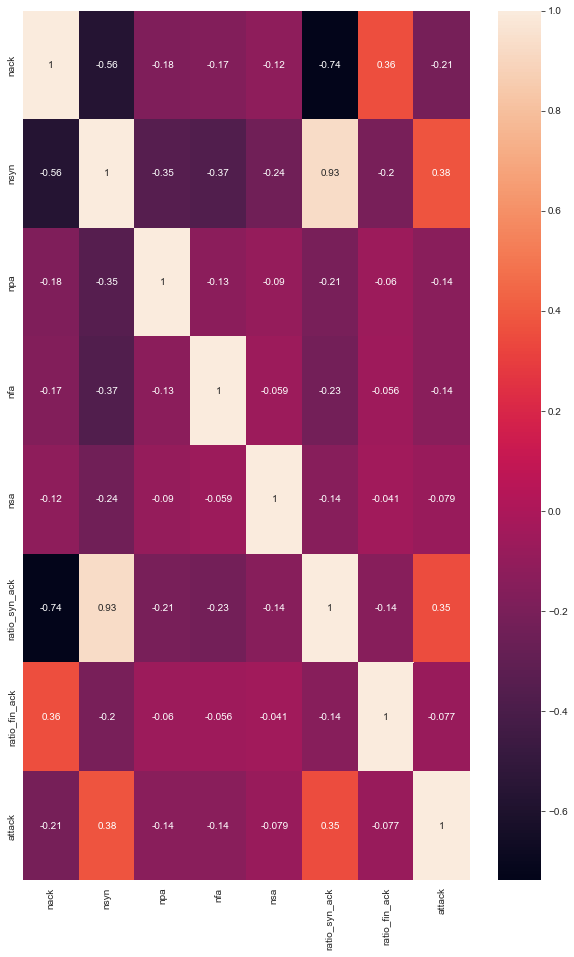

In [62]:
# The spearmanr() function from the scipy library calculates the Spearman's correlation coefficient between all pairs of variables in the dataset, and returns a matrix of the correlation coefficients. The underscore in the code is used to ignore the p-value associated with each correlation coefficient. Finally, the correlation matrix is printed using the print() function.

print("Step 6: Calculating Correlation between variables:")

# calculate the Spearman's correlation matrix
corr_matrix, _ = spearmanr(extracted_num_data)

# print the correlation matrix
df_corr = pd.DataFrame(corr_matrix, columns=extracted_num_data.columns, index=extracted_num_data.columns)
df_corr.to_csv('Datasets/correlation.csv')
# format the DataFrame for printing
# df_corr = df_corr.style.background_gradient(cmap='coolwarm')

# print the formatted DataFrame
print(df_corr.T)

# sns.set(font_scale=1.2)
plt.figure(figsize=(10, 16))
sns.heatmap(extracted_num_data.corr(), annot= True)

In [20]:
# drop variables with poor correlation
print("Step 7: Optional Drop variables with poor correlation!!!")
extracted_data = extracted_data.drop(extracted_data.columns[2], axis = 1)

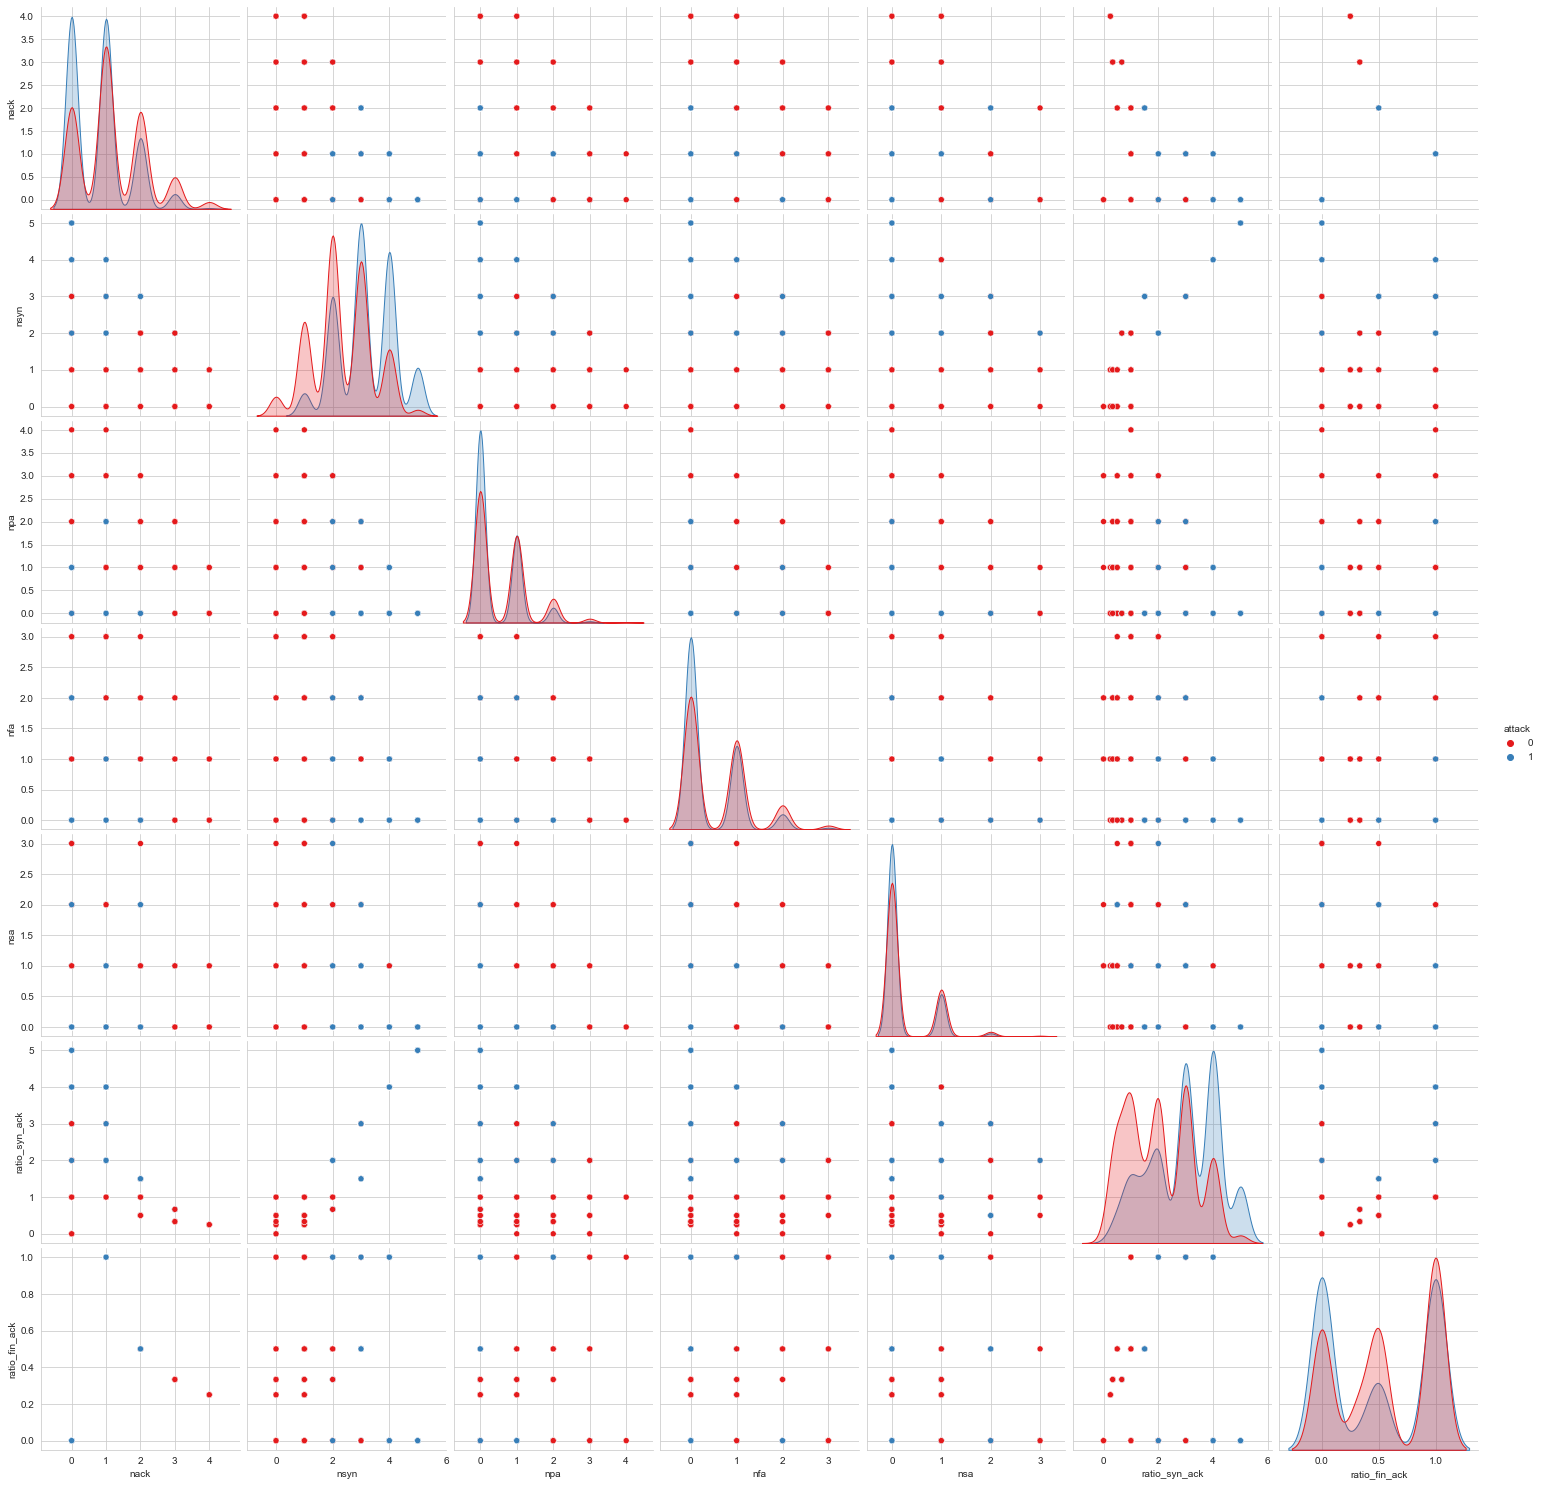

In [63]:

sns.set_style("whitegrid")
sns.pairplot(extracted_num_data, height=3, hue="attack", palette="Set1")

In [40]:
# print(extracted_data.shape)


(5200, 11)


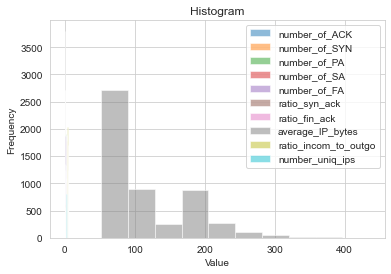

<Figure size 720x1152 with 0 Axes>

In [41]:
# # Create a list of variables to plot
# # vars_to_plot = extracted_data[['number_of_ACK','number_of_SYN','number_of_PA','number_of_SA','number_of_FA','ratio_syn_ack', 'ratio_fin_ack','average_IP_bytes','ratio_incom_to_outgo','number_uniq_ips']]

# # Plot the histogram
# plt.hist(extracted_data['number_of_ACK'], bins=10, alpha=0.5, label=['number_of_ACK'])
# plt.hist(extracted_data['number_of_SYN'], bins=10, alpha=0.5, label=['number_of_SYN'])
# plt.hist(extracted_data['number_of_PA'], bins=10, alpha=0.5, label=['number_of_PA'])
# plt.hist(extracted_data['number_of_SA'], bins=10, alpha=0.5, label=['number_of_SA'])
# plt.hist(extracted_data['number_of_FA'], bins=10, alpha=0.5, label=['number_of_FA'])
# plt.hist(extracted_data['ratio_syn_ack'], bins=10, alpha=0.5, label=['ratio_syn_ack'])
# plt.hist(extracted_data['ratio_fin_ack'], bins=10, alpha=0.5, label=['ratio_fin_ack'])
# plt.hist(extracted_data['average_IP_bytes'], bins=10, alpha=0.5, label=['average_IP_bytes'])
# plt.hist(extracted_data['ratio_incom_to_outgo'], bins=10, alpha=0.5, label=['ratio_incom_to_outgo'])
# plt.hist(extracted_data['number_uniq_ips'], bins=10, alpha=0.5, label=['number_uniq_ips'])



# # Add axis labels and title
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram')

# # Add a legend
# plt.legend()

# # Show the plot
# plt.figure(figsize=(10, 16))
# plt.show()


In [14]:
# split the datasets into training and testing
y = extracted_num_data ['attack']
x = extracted_num_data.loc[:, extracted_num_data.columns != 'attack']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

train_data = pd.concat([x_train, y_train], axis=1)
test_data = pd.concat([x_test, y_test], axis=1)

print("Shape of training data for features: ",x_train.shape)
print("Shape of testing data for features: ",x_test.shape)
print("Shape of training data for class: ",y_train.shape)
print("Shape of testing data for class: ",y_test.shape)
# print("First 5 values of training data",train_data.head())

Shape of training data for features:  (3200, 7)
Shape of testing data for features:  (800, 7)
Shape of training data for class:  (3200,)
Shape of testing data for class:  (800,)


In [15]:
print("\n Step 8: Normalize the dataset!!!")
scaler = MinMaxScaler()

# fit and transform the data
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.fit_transform(x_test)
# Print the normalized data
print("Normalized Training data:\n ", x_train_normalized)
print("Normalized Testing data:\n ",x_test_normalized)


 Step 8: Normalize the dataset!!!
Normalized Training data:
  [[0.75       0.4        0.         ... 0.         0.13333333 0.33333333]
 [0.25       0.4        0.         ... 0.         0.4        1.        ]
 [0.         0.6        0.25       ... 0.         0.6        0.        ]
 ...
 [0.         1.         0.         ... 0.         1.         0.        ]
 [0.         0.6        0.         ... 0.33333333 0.6        0.        ]
 [0.         0.8        0.25       ... 0.         0.8        0.        ]]
Normalized Testing data:
  [[0.25       0.4        0.66666667 ... 0.         0.4        1.        ]
 [0.5        0.4        0.         ... 0.5        0.2        0.5       ]
 [0.         0.6        0.         ... 1.         0.6        0.        ]
 ...
 [0.5        0.4        0.         ... 0.         0.2        0.5       ]
 [0.5        0.6        0.         ... 0.         0.3        0.5       ]
 [0.25       0.8        0.         ... 0.         0.8        1.        ]]


In [16]:
print("\n Step 9: Starting with modelling!!!")
x_train = train_data.drop(labels = ["attack"],axis = 1)
x_test = test_data.drop(labels = ["attack"],axis = 1)

y_train = train_data["attack"]
y_test = test_data["attack"]
print("Printing Dimensions!!!")
print("Dimensions of features of training data: ", x_train.shape)
print("Dimensions of features of testing data", x_test.shape)
print("Dimensions of class features of training data", y_train.shape)
print("Dimensions of class features of testing data", y_test.shape)



 Step 9: Starting with modelling!!!
Printing Dimensions!!!
Dimensions of features of training data:  (3200, 7)
Dimensions of features of testing data (800, 7)
Dimensions of class features of training data (3200,)
Dimensions of class features of testing data (800,)


Step 10: Testing certain algorithms!!!
Accuracy of LR: 0.6825
Confusion Matrix of LR: 



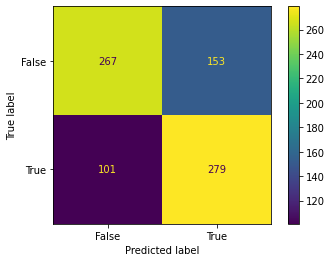

Accuracy Random Forest: 0.68375
Confusion Matrix of Random Forest: 



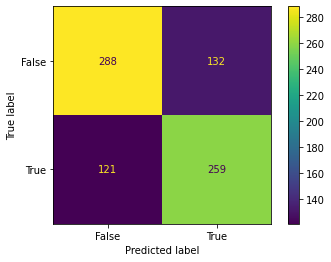

Accuracy of KNN: 0.64375
Confusion Matrix of KNN: 



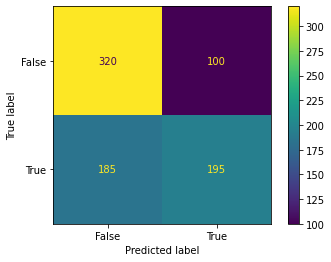

Accuracy of Gaussian NB: 0.6725
Confusion Matrix of Gaussian NB: 



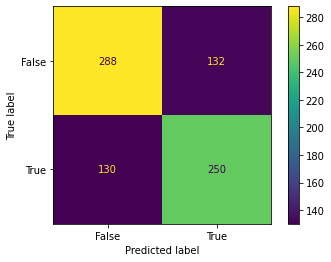

Accuracy of Decision Tree: 0.68375
Confusion Matrix of Decision Tree



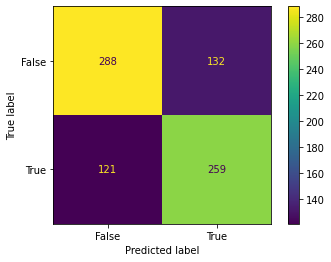

Accuracy of SVM Sigmoid: 0.41875
Confusion Matrix of SVM Sigmoid: 



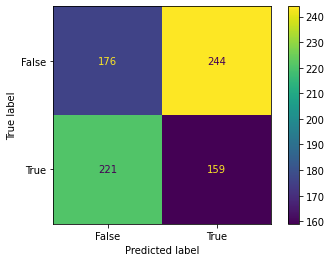

Accuracy of SVM Polynomial: 0.6775
Confusion Matrix of SVM Polynomial: 



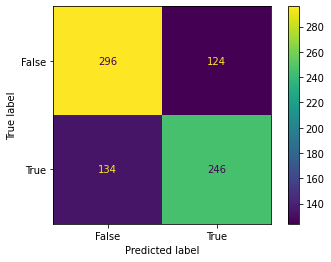

Accuracy using SVM RBF: 0.68375
Confusion Matrix of SVM RBF: 



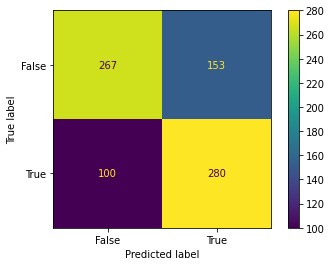

Accuracy using MLP Classifier: 0.68
Confusion Matrix of MLP Classifier: 



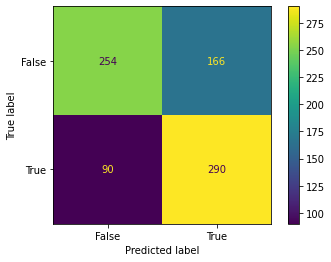

In [17]:
print("Step 10: Testing certain algorithms!!!") 


# Train model
clf_LR = LogisticRegression()
clf_LR.fit(x_train, y_train)

# Test model
y_pred_LR = clf_LR.predict(x_test)
accuracy_LR = metrics.accuracy_score(y_test, y_pred_LR)
print('Accuracy of LR:', accuracy_LR)
cm_LR = metrics.confusion_matrix(y_test, y_pred_LR)
cm_display_LR = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_LR, display_labels = [False, True])

cm_display_LR.plot()
print('Confusion Matrix of LR: \n')
plt.show()


# Train model random forest
clf_RF = RandomForestClassifier()
clf_RF.fit(x_train, y_train)

# Test model
y_pred_RF = clf_RF.predict(x_test)
accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
print('Accuracy Random Forest:', accuracy_RF)
cm_RF = metrics.confusion_matrix(y_test, y_pred_RF)
cm_display_RF = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_RF, display_labels = [False, True])

cm_display_RF.plot()
print('Confusion Matrix of Random Forest: \n')
plt.show()



# Train model
clf_KNN = KNeighborsClassifier()
clf_KNN.fit(x_train, y_train)

# Test model
y_pred_KNN = clf_KNN.predict(x_test)
accuracy_KNN = metrics.accuracy_score(y_test, y_pred_KNN)
print('Accuracy of KNN:', accuracy_KNN)
cm_KNN = metrics.confusion_matrix(y_test, y_pred_KNN)
cm_display_KNN = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_KNN, display_labels = [False, True])

cm_display_KNN.plot()
print('Confusion Matrix of KNN: \n')
plt.show()


# Train model
clf_GNB = GaussianNB()
clf_GNB.fit(x_train, y_train)

# Test model
y_pred_GNB = clf_GNB.predict(x_test)
accuracy_GNB = metrics.accuracy_score(y_test, y_pred_GNB)
print('Accuracy of Gaussian NB:', accuracy_GNB)
cm_GNB = metrics.confusion_matrix(y_test, y_pred_GNB)
cm_display_GNB = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_GNB, display_labels = [False, True])

cm_display_GNB.plot()
print('Confusion Matrix of Gaussian NB: \n')
plt.show()


# Train model
clf_DT = DecisionTreeClassifier()
clf_DT.fit(x_train, y_train)

# Test model
y_pred_DT = clf_DT.predict(x_test)
accuracy_DT = metrics.accuracy_score(y_test, y_pred_DT)
print('Accuracy of Decision Tree:', accuracy_DT)
cm_DT = metrics.confusion_matrix(y_test, y_pred_DT)

cm_display_DT = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_DT, display_labels = [False, True])

cm_display_DT.plot()
print('Confusion Matrix of Decision Tree\n')
plt.show()

# Train model
clf_SVS = SVC(kernel='sigmoid')
clf_SVS.fit(x_train, y_train)

# Test model
y_pred_SVS = clf_SVS.predict(x_test)
accuracy_SVS = metrics.accuracy_score(y_test, y_pred_SVS)
print('Accuracy of SVM Sigmoid:', accuracy_SVS)
cm_SVS = metrics.confusion_matrix(y_test, y_pred_SVS)
cm_display_SVS = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_SVS, display_labels = [False, True])

cm_display_SVS.plot()
print('Confusion Matrix of SVM Sigmoid: \n')
plt.show()


# Train model
clf_SVP = SVC(kernel='poly', degree=3)
clf_SVP.fit(x_train, y_train)

# Test model
y_pred_SVP = clf_SVP.predict(x_test)
accuracy_SVP = metrics.accuracy_score(y_test, y_pred_SVP)
print('Accuracy of SVM Polynomial:', accuracy_SVP)
cm_SVP = metrics.confusion_matrix(y_test, y_pred_SVP)
cm_display_SVP = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_SVP, display_labels = [False, True])

cm_display_SVP.plot()
print('Confusion Matrix of SVM Polynomial: \n')
plt.show()

# Train model
clf_SVRBF = SVC(kernel='rbf')
clf_SVRBF.fit(x_train, y_train)

# Test model
y_pred_SVRBF = clf_SVRBF.predict(x_test)
accuracy_SVRBF = metrics.accuracy_score(y_test, y_pred_SVRBF)
print('Accuracy using SVM RBF:', accuracy_SVRBF)
cm_SVRBF = metrics.confusion_matrix(y_test, y_pred_SVRBF)
cm_display_SVRBF = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_SVRBF, display_labels = [False, True])

cm_display_SVRBF.plot()
print('Confusion Matrix of SVM RBF: \n')
plt.show()


# Create an MLP classifier
clf_mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)

# Train the MLP classifier
clf_mlp.fit(x_train, y_train)

# Make predictions on the testing set
y_pred_mlp = clf_mlp.predict(x_test)

# Evaluate the accuracy of the model
accuracy_mlp = metrics.accuracy_score(y_test, y_pred_mlp)
print('Accuracy using MLP Classifier:', accuracy_mlp)
cm_mlp = metrics.confusion_matrix(y_test, y_pred_mlp)
cm_display_mlp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_mlp, display_labels = [False, True])

cm_display_mlp.plot()
print('Confusion Matrix of MLP Classifier: \n')
plt.show()



In [21]:
pip install seaborn

You should consider upgrading via the 'c:\python\python38\python.exe -m pip install --upgrade pip' command.


In [75]:
# Python code demonstrate creating
# DataFrame from dict narray / lists
# By default addresses.

# import pandas as pd

# initialise data of lists.
data = {'Name':['Tom', 'nick', 'krish', 'jack'], 'Age':[20, 21, 19, 18]}

# Create DataFrame
df = pd.DataFrame(data)
print(df[0:2])
# Print the output.
i=0
print(df.shape[0])
print(df)
print("")
print(df[i:df.shape[0]])


   Name  Age
0   Tom   20
1  nick   21
4
    Name  Age
0    Tom   20
1   nick   21
2  krish   19
3   jack   18

    Name  Age
0    Tom   20
1   nick   21
2  krish   19
3   jack   18


In [19]:
extracted_data.dtypes

number_of_ACK             int64
number_of_SYN             int64
number_of_PA              int64
number_of_FA              int64
number_of_SA              int64
ratio_syn_ack           float64
ratio_fin_ack           float64
average_IP_bytes        float64
ratio_incom_to_outgo    float64
number_uniq_ips           int64
attack                    int64
dtype: object